<a href="https://colab.research.google.com/github/jaflo/word-unusuality/blob/master/detect_codeswitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Identification of Intra-Word Code-Switching of German and English

The system described below allows for identification of intra-word code-switching in a German-English mixed text without the need for training data with labels identifying intra-word code-switched words. The system is composed of a semi-supervised LSTM RNN and a language ratio filter.

This notebook accompanies an unpublished paper. It has been made available to encourage reproduction of the documented results and processes. While the results leave room for improvement, the hope is that the availability of this code will result in future research in the area.

## Execution environment

This notebook is set up to run in [Google Colab](https://colab.research.google.com/) on [Cloud TPUs](https://cloud.google.com/tpu/). At time of writing, you can make use of these resources for no monetary charge.

If you are viewing this in Colab, make sure that TPU usage is enabled for your runtime. You can do this by selecting Runtime > Change runtime type > Hardware accelerator > TPU. The code also persists data in your Google Drive in a top-level folder called Colab.

In [0]:
# This notebook is licensed under the MIT license. You should have received a
# copy of the license with this notebook. If not, you can retrieve a copy here:
# https://opensource.org/licenses/MIT

# This notebook includes code from the the Cloud TPU reference notebook.
# The original can be found here:
# https://github.com/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb
# Cells that use code from that notebook include a comment noting changes if any
# were made. The reference notebook is licensed under the Apache License 2.0:

# ==============================================================================
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Setup

* Connects to Google Drive
* Installs dictionaries
* Installs Python libraries
* Imports a bunch of stuff
* Configures matplotlib

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install enchant myspell-de-de
!pip install pyenchant
!pip install -U morfessor

from collections import Counter
import enchant
import os
import math
import distutils
import random
import re
import csv
import matplotlib.pyplot as plt

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tqdm import tqdm
import morfessor
from nltk.metrics.agreement import AnnotationTask

import tensorflow as tf
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/shakespeare_with_tpu_and_keras.ipynb')
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-de-de
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell libreoffice-writer libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-com

### Download language data

This downloads

* German and English Wikipedia data from Leipzig Corpora: http://wortschatz.uni-leipzig.de/en/download/
* Lists of German words for Morfessor: http://morpho.aalto.fi/events/morphochallenge2010/datasets.shtml
* List of German nouns: https://github.com/gambolputty/german-nouns

In [0]:
# http://wortschatz.uni-leipzig.de/en/download/ 10K - 1M

!wget --show-progress -nc --continue -P /content http://pcai056.informatik.uni-leipzig.de/downloads/corpora/deu_wikipedia_2016_1M.tar.gz
!wget --show-progress -nc --continue -P /content http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng_wikipedia_2016_1M.tar.gz

!for i in /content/*.tar.gz; do tar -xvf $i ; done
!wc -l /content/*_*_20*/*-sentences.txt

# http://morpho.aalto.fi/events/morphochallenge2010/datasets.shtml

!wget --show-progress -nc --continue -P /content http://morpho.aalto.fi/events/morphochallenge2010/data/wordlist-2010.ger

# https://github.com/gambolputty/german-nouns

!wget --show-progress -nc --continue -P /content https://raw.githubusercontent.com/gambolputty/german-nouns/master/nouns.csv

deu_nouns = set()

with open('nouns.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  header = True
  for row in csv_reader:
    if not header:
      deu_nouns.add(row[0])
    header = False

len(deu_nouns)

--2019-11-19 03:59:49--  http://pcai056.informatik.uni-leipzig.de/downloads/corpora/deu_wikipedia_2016_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239079561 (228M) [application/x-gzip]
Saving to: ‘/content/deu_wikipedia_2016_1M.tar.gz’

deu_wikipedia_2016_ 100%[===================>] 228.00M  23.8MB/s    in 11s     

2019-11-19 04:00:00 (21.7 MB/s) - ‘/content/deu_wikipedia_2016_1M.tar.gz’ saved [239079561/239079561]

--2019-11-19 04:00:00--  http://pcai056.informatik.uni-leipzig.de/downloads/corpora/eng_wikipedia_2016_1M.tar.gz
Resolving pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)... 139.18.2.216
Connecting to pcai056.informatik.uni-leipzig.de (pcai056.informatik.uni-leipzig.de)|139.18.2.216|:80... connected.
HTTP request sent, awai

81214

### Train Morfessor

Trains Morfessor if needed, which can take a while.

In [0]:
![ -f "/content/drive/My Drive/Colab/deu_morfessor_model.bin" ] || morfessor-train --encoding=ISO_8859-15 --traindata-list --logfile=log.log -s "/content/drive/My Drive/Colab/deu_morfessor_model.bin" -d ones /content/wordlist-2010.ger

io = morfessor.MorfessorIO()
model = io.read_binary_model_file('/content/drive/My Drive/Colab/deu_morfessor_model.bin')

### Transform functions

Some helpful functions from the reference notebook.

In [0]:
# From reference notebook

def transform(txt):
  return np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)

def input_fn(corpus_file, seq_len=100, batch_size=1024):
  """Return a dataset of source and target sequences for training."""
  with tf.io.gfile.GFile(corpus_file, 'r') as f:
    txt = f.read()

  txt = " ".join([line.split("\t", maxsplit=1)[1] for line in txt.split("\n") if "\t" in line])

  source = tf.constant(transform(txt), dtype=tf.int32)

  ds = tf.data.Dataset.from_tensor_slices(source).batch(seq_len+1, drop_remainder=True)

  def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

  BUFFER_SIZE = 10000
  ds = ds.map(split_input_target).shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

  return ds.repeat()

### Build the model

The model is defined as a two-layer, forward-LSTM, the same model should work both on CPU and TPU.

In [0]:
# From reference notebook, adds a dropout layer

EMBEDDING_DIM = 512

def lstm_model(seq_len=100, batch_size=None, stateful=True):
  """Language model: predict the next word given the current word."""
  source = tf.keras.Input(
      name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

  embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
  lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
  lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
  dropout = tf.keras.layers.Dropout(0.5)(lstm_2)
  predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(dropout)

  return tf.keras.Model(inputs=[source], outputs=[predicted_char])

### Train the model

Sets up the TPUs and defines a function to train and save the model.

In [0]:
# From reference notebook

print("Setting up TPUs...")
tf.keras.backend.clear_session()

resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

# Wraps code from reference, changed number of epochs

def train_model(corpus_file, model_dest):
  print("Compiling model...")
  with strategy.scope():
    training_model = lstm_model(seq_len=100, stateful=False)
    training_model.summary()
    training_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

  print("Starting training using %s..." % corpus_file)
  training_model.fit(
    input_fn(corpus_file),
    steps_per_epoch=100,
    epochs=30
  )

  print("Saving model to %s..." % model_dest)
  training_model.save_weights(model_dest, overwrite=True)

  return training_model

Setting up TPUs...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: 10.105.206.2:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.105.206.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9657048963938183205)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 63842

In [0]:
# From reference, only runs one batch

def load_model(model_weight_file):
  print("Loading model from %s..." % model_weight_file)
  # Keras requires the batch size be specified ahead of time for stateful models.
  # We use a sequence length of 1, as we will be feeding in one character at a 
  # time and predicting the next character.
  prediction_model = lstm_model(seq_len=1, batch_size=1, stateful=True)
  prediction_model.load_weights(model_weight_file)
  return prediction_model

## Find character probabilities

Loads the models or trains one if needed. Uses the trained model to make predictions of a given character being the next character.

In [0]:
models = {}
langs = ["deu", "eng"]

for lang in langs:
  model_weights = '/content/drive/My Drive/Colab/%s_weights.h5' % lang
  if not os.path.isfile(model_weights):
    train_model('/content/%s_wikipedia_2016_1M/%s_wikipedia_2016_1M-sentences.txt' % (lang, lang), model_weights)
  models[lang] = load_model(model_weights)

Loading model from /content/drive/My Drive/Colab/deu_weights.h5...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading model from /content/drive/My Drive/Colab/eng_weights.h5...


In [0]:
def get_random_text(lang, line_count=200):
  corpus_file = '/content/%s_wikipedia_2016_1M/%s_wikipedia_2016_1M-sentences.txt' % (lang, lang)

  with tf.io.gfile.GFile(corpus_file, 'r') as f:
    txt = f.read()

  lines = [line.split("\t", maxsplit=1)[1] for line in txt.split("\n") if "\t" in line]
  random.shuffle(lines)
  return " ".join(lines[:line_count]) + " "

In [0]:
# From reference, seeds with spaces always, constant batch size, collect probabilities instead of generating text

def get_char_probabilites(prediction_model, test_text):
  # We seed the model with our initial string, copied BATCH_SIZE times
  seed_txt = " "
  seed = transform(seed_txt)
  seed = np.repeat(np.expand_dims(seed, 0), 1, axis=0)

  test = transform(test_text)

  # First, run the seed forward to prime the state of the model.
  prediction_model.reset_states()
  for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

  # Now we can accumulate predictions!
  probabilities = []
  for i, codepoint in enumerate(test):
    last_word = [np.repeat(test[i-1], 1, axis=0)] if i > 0 else seed[:, -1:]
    next_probits = prediction_model.predict(last_word)[:, 0, :]

    # get this chars probability from the distribution
    probabilities.append(next_probits[0][codepoint])

  return probabilities

## Find word unusuality

Let $p_i$ be the probability of the $i$-th character of a word of length $n$ as predicted by the model. Then the unusuality of an entire word is:

$$-\sqrt{n}\log\left(\prod_{i=1}^{n} p_i\right)$$

which is equal to:

$$-\sqrt{n}\sum_{i=1}^{n} \log\left(p_i\right)$$


In [0]:
def standard_unusuality_measure(char_probs):
  product = 1
  for p in char_probs:
    product *= p
  return -math.log(product) * math.sqrt(len(char_probs))

def get_word_probs(test_text, probabilities, measure=standard_unusuality_measure):
  total_p = 1
  word = ""

  words = []
  word_probs = []
  char_probs = []

  for i, (c, p) in enumerate(zip(test_text, probabilities)):
    if c.isalpha():
      total_p *= p
      word += c
      char_probs.append(p)
    elif len(word) > 0:
      words.append(word)
      word_probs.append(measure(char_probs))
      total_p = 1
      word = ""
      char_probs = []
  
  return words, np.nan_to_num(word_probs)

Find the distributions of scores on some example sentences.

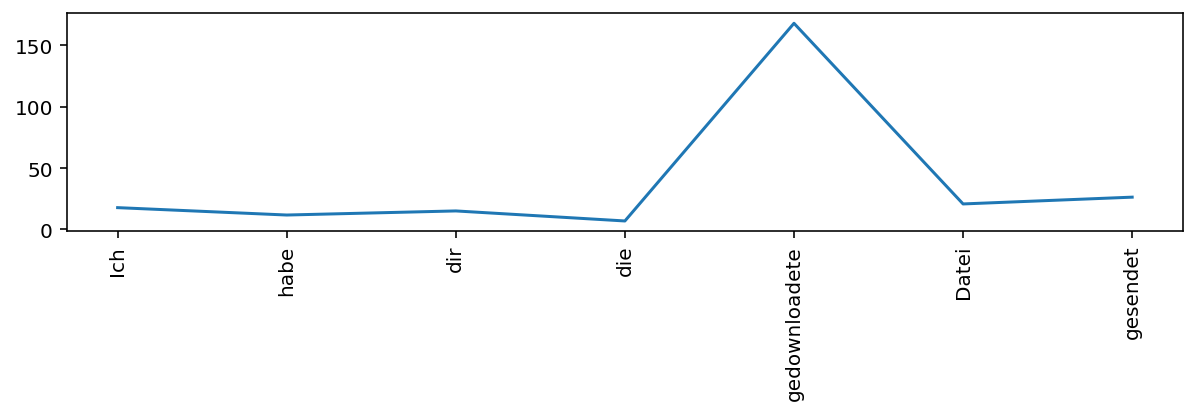

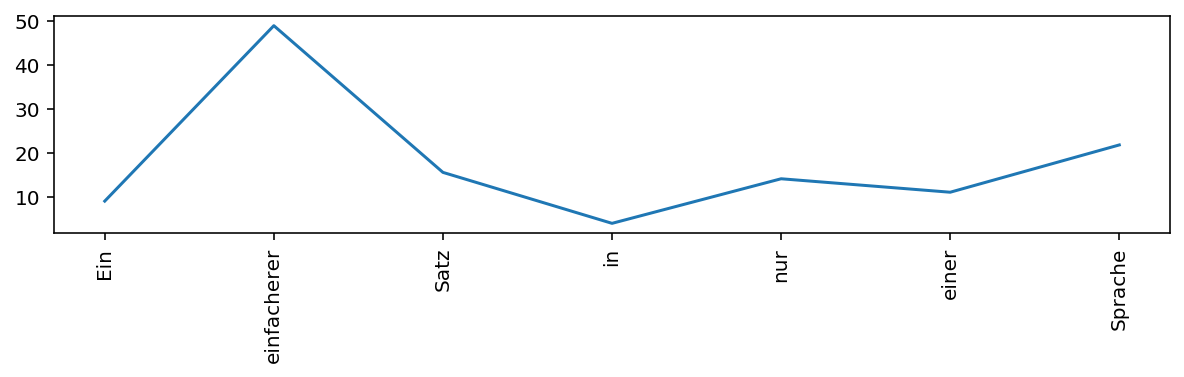

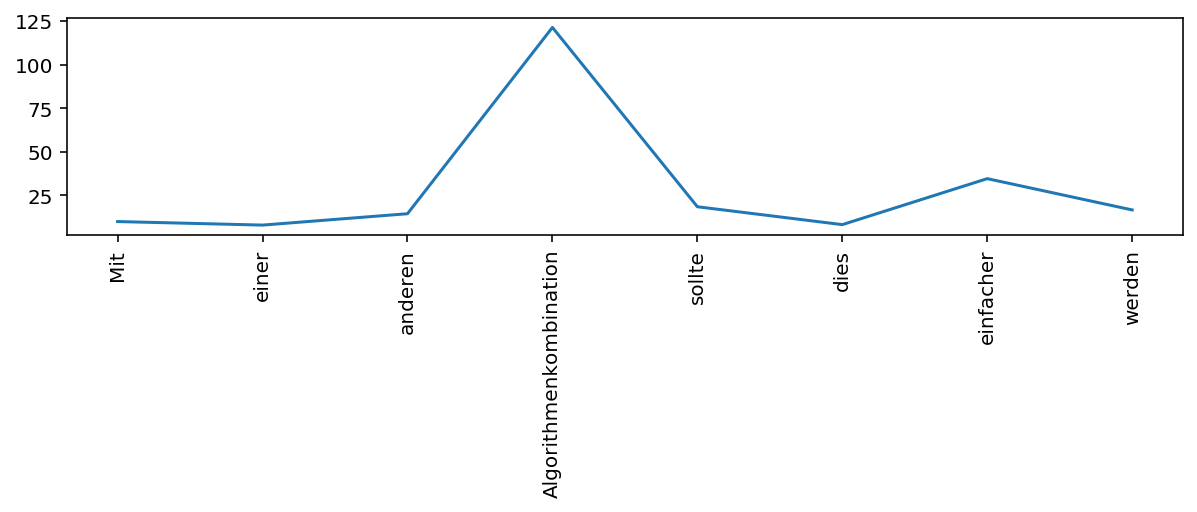

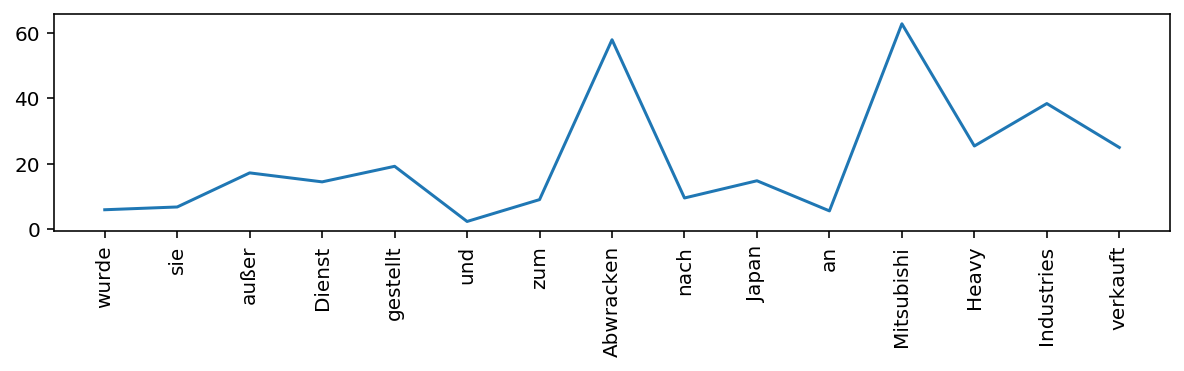

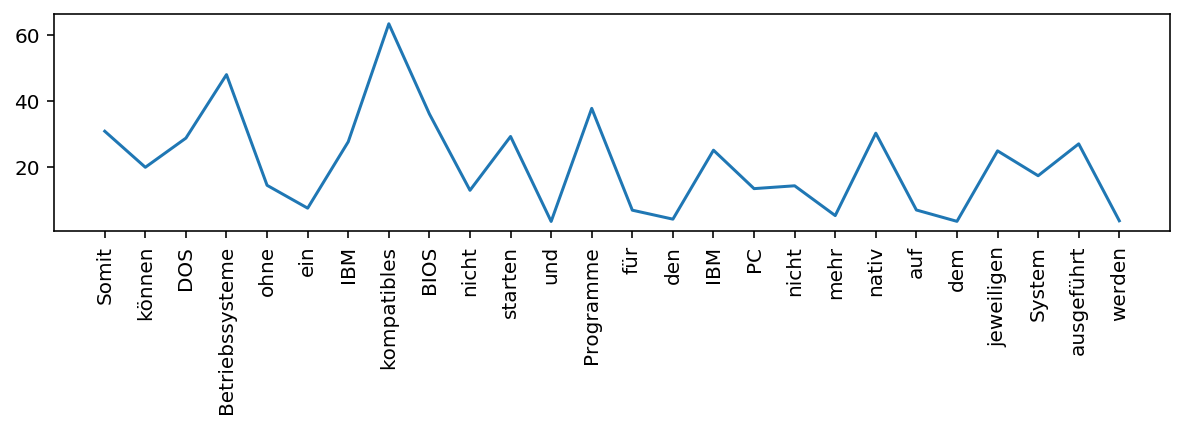

In [0]:
test_texts = [
  "Ich habe dir die gedownloadete Datei gesendet.",
  "Ein einfacherer Satz in nur einer Sprache.",
  "Mit einer anderen Algorithmenkombination sollte dies einfacher werden."
]

for _ in range(2):
  test_texts.append(get_random_text("deu", line_count=1))

sent_data = {}
high, low = 0, 0

for sent in test_texts:
  probabilities = get_char_probabilites(models["deu"], sent)
  words, word_probs = get_word_probs(sent, probabilities)
  sent_data[sent] = (words, word_probs)

  high = max(max(word_probs), high)
  low = min(min(word_probs), low)

for (words, word_probs) in sent_data.values():
  x = range(len(words))
  plt.figure(figsize=(10,2))
  plt.plot(x, word_probs)
  plt.xticks(x, words, rotation='vertical')
  plt.show()

## Find unexpected words

Uses the word probabilities from earlier to cluster together unusual words.

In [0]:
def get_unexpected_words(lang, test_text):
  test_text += " "
  probabilities = get_char_probabilites(models[lang], test_text)
  words, word_probs = get_word_probs(test_text, probabilities)
  clustering = KMeans(n_clusters=2).fit_predict(word_probs.reshape(-1, 1))

  a = [x for i, x in enumerate(word_probs) if clustering[i] == 0]
  b = [x for i, x in enumerate(word_probs) if clustering[i] == 1]
  target_cluster, count = Counter(clustering).most_common()[-1]

  unusual = []
  if count < len(words):
    unusual = [x for i, x in enumerate(words) if clustering[i] == target_cluster]

  return unusual

def get_unusual(sent):
  firstLang = True
  overlap = set()
  for lang in langs:
    unusual = get_unexpected_words(lang, sent)
    if firstLang:
      overlap = set(unusual)
      firstLang = False
    else:
      overlap = overlap.intersection(unusual)
  return sorted(list(overlap)) if overlap else []

for t in test_texts:
  print(t)
  print("unusual", get_unusual(t))

Ich habe dir die gedownloadete Datei gesendet.
unusual ['gedownloadete']
Ein einfacherer Satz in nur einer Sprache.
unusual ['einfacherer']
Mit einer anderen Algorithmenkombination sollte dies einfacher werden.
unusual ['Algorithmenkombination']
1958 wurde sie außer Dienst gestellt und zum Abwracken nach Japan an Mitsubishi Heavy Industries verkauft. 
unusual ['Abwracken', 'Mitsubishi']
Somit können DOS-Betriebssysteme ohne ein IBM-kompatibles BIOS nicht starten und Programme für den IBM-PC nicht mehr nativ auf dem jeweiligen System ausgeführt werden. 
unusual ['Betriebssysteme', 'ausgeführt', 'jeweiligen', 'kompatibles']


## Language ratios

Find the language ratio of a word by breaking it down into its morphemes with Morfessor.

In [0]:
english = enchant.Dict("en_US")
german = enchant.Dict("de_DE")

def groupings(pieces):
  result = []
  for start in range(len(pieces)):
    for end in range(len(pieces) + 1):
      if start == end or start > end:
        continue
      before = "".join(pieces[:start])
      during = "".join(pieces[start:end])
      after = "".join(pieces[end:])
      result.append((before, during, after))
  return result

def avg(a):
  if len(a) == 0:
    return 0
  return sum(a) / len(a)

def lang_ratio(word):
  morph_groups = model.viterbi_nbest(word, 10)
  eng = []
  ger = []
  added_morph_groups = set()
  for group in morph_groups:
    morphemes, score = group
    score = 1 - (score/100)
    for candidate in groupings(morphemes):
      before, middle, after = candidate
      if len(middle) <= 2 or middle in added_morph_groups:
        continue
      boost = len(middle) / len(word)
      added_morph_groups.add(middle)
      if english.check(middle):
        eng.append(score * boost)
      if (middle.title() == middle and middle in deu_nouns):# \
        ger.append(score * boost)
  if len(ger) == 0:
    return 0 if german.check(word) else 1
  return avg(eng)/avg(ger)

lang_ratio("initially")

for w in "Brasilien abchecken clicken eingeloggt fiktiven initially".split(" "):
  print(lang_ratio(w), w)

0.48149587738468486 Brasilien
1 abchecken
1 clicken
0 eingeloggt
0 fiktiven
1 initially


## Find mixed language words

Combines the two functions to find words that are likely to be intra-word code-switched.

In [0]:
def get_mixed(sent, matrix_lang="deu"):
  unusual = get_unusual(sent)
  if matrix_lang == "deu":
    return [w for w in unusual if lang_ratio(w) >= 1]
  elif matrix_lang == "eng":
    return [w for w in unusual if lang_ratio(w) <= 1]
  else:
    print("Unknown language", matrix_lang)
    return []

for t in test_texts:
  print(t)
  print("unusual", get_unusual(t))
  print("filtered", get_mixed(t))

Ich habe dir die gedownloadete Datei gesendet.
unusual ['gedownloadete']
filtered ['gedownloadete']
Ein einfacherer Satz in nur einer Sprache.
unusual ['einfacherer']
filtered []
Mit einer anderen Algorithmenkombination sollte dies einfacher werden.
unusual ['Algorithmenkombination']
filtered ['Algorithmenkombination']
1958 wurde sie außer Dienst gestellt und zum Abwracken nach Japan an Mitsubishi Heavy Industries verkauft. 
unusual ['Abwracken', 'Mitsubishi']
filtered []
Somit können DOS-Betriebssysteme ohne ein IBM-kompatibles BIOS nicht starten und Programme für den IBM-PC nicht mehr nativ auf dem jeweiligen System ausgeführt werden. 
unusual ['Betriebssysteme', 'ausgeführt', 'jeweiligen', 'kompatibles']
filtered []


## Testing

We have tagged language data, let's test the model.

In [0]:
is_first = True
documents = {}

with open("/content/drive/My Drive/Colab/words.tsv") as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t', quotechar=None)
  for row in reader:
    if is_first:
      is_first = False
      continue
    doc_id, word, tag = row[0], row[1], row[6]
    if doc_id not in documents:
      documents[doc_id] = {
        "Complete": []
      }
    if tag not in documents[doc_id]:
      documents[doc_id][tag] = []
    documents[doc_id][tag].append(word)
    documents[doc_id]["Complete"].append(word)

is_first = True
texts = {}

with open("/content/drive/My Drive/Colab/corpora.tsv") as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t', quotechar=None)
  for row in reader:
    if is_first:
      is_first = False
      continue
    doc_id, text = row[0], row[1]
    texts[doc_id] = text

sample_text = random.choice(list(texts.items()))
sample_doc_id = sample_text[0]
labels = ["Named Entity", "German", "Integrated", "Mixed", "English", "Other"]

sample_doc_id

'foadvvTi2k15mCTqFGUn'

In [0]:
def get_true_labels(doc_id, mixed_labels=["Mixed"]):
  true_labels = []
  document = documents[doc_id]
  for word in document["Complete"]:
    if word not in document[""]:
      if any([label in document and word in document[label] for label in mixed_labels]):
        true_labels.append(1)
      else:
        true_labels.append(0)
  return np.array(true_labels)

get_true_labels(sample_doc_id)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [0]:
def get_pred_labels(doc_id, predictor=get_mixed):
  pred_labels = []
  predicted_mixed = []

  sents = re.split(r'([^0-9][:;.]\s+)', texts[doc_id] + " ")
  sents = [sent.strip() for sent in sents if sent]
  sents = [a + b for a,b in zip(sents[0::2], sents[1::2])]
  for sent in sents:
    if len(re.split(r'[^a-zA-Z0-9]', sent)) > 2:
      predicted_mixed.extend(predictor(sent))

  document = documents[doc_id]
  for word in document["Complete"]:
    if word not in document[""]:
      if word in predicted_mixed:
        pred_labels.append(1)
      else:
        pred_labels.append(0)
  return np.array(pred_labels)

get_pred_labels(sample_doc_id)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
print(classification_report(
  get_true_labels(sample_doc_id), 
  get_pred_labels(sample_doc_id), target_names=["Other", "Mixed"]))

print(classification_report(
  get_true_labels(sample_doc_id), 
  get_pred_labels(sample_doc_id, predictor=get_unusual), target_names=["Other", "Mixed"]))

              precision    recall  f1-score   support

       Other       0.99      1.00      0.99        97
       Mixed       1.00      0.50      0.67         2

    accuracy                           0.99        99
   macro avg       0.99      0.75      0.83        99
weighted avg       0.99      0.99      0.99        99

              precision    recall  f1-score   support

       Other       0.99      0.82      0.90        97
       Mixed       0.06      0.50      0.10         2

    accuracy                           0.82        99
   macro avg       0.52      0.66      0.50        99
weighted avg       0.97      0.82      0.88        99



In [0]:
def get_words(doc_id):
  document = documents[doc_id]
  return [w for w in document["Complete"] if w not in document[""]]

get_words(sample_doc_id)[:5]

['In', 'diesem', 'Artikel', 'wird', 'gezeigt']

In [0]:
pred_mixed = {}
pred_unusual = {}
words = []

for doc_id in tqdm(texts.keys()):
  pred_mixed[doc_id] = get_pred_labels(doc_id)
  pred_unusual[doc_id] = get_pred_labels(doc_id, predictor=get_unusual)
  words.extend(get_words(doc_id))

100%|██████████| 88/88 [37:21<00:00, 22.63s/it]


### Performance

Let's get some benchmarks for our results.

In [0]:
for pred in [pred_unusual, pred_mixed]:
  all_pred = []
  all_true = []

  for doc_id in texts.keys():
    all_pred.extend(pred[doc_id]) # cached get_pred_labels(doc_id)
    all_true.extend(get_true_labels(doc_id))

  print("scored", round(f1_score(all_true, all_pred), 4))
  print(classification_report(all_true, all_pred, target_names=["Other", "Mixed"], digits=4))


scored 0.1102
              precision    recall  f1-score   support

       Other     0.9976    0.8516    0.9189      8371
       Mixed     0.0591    0.8211    0.1102        95

    accuracy                         0.8513      8466
   macro avg     0.5284    0.8363    0.5146      8466
weighted avg     0.9871    0.8513    0.9098      8466

scored 0.2449
              precision    recall  f1-score   support

       Other     0.9915    0.9908    0.9912      8371
       Mixed     0.2376    0.2526    0.2449        95

    accuracy                         0.9825      8466
   macro avg     0.6146    0.6217    0.6180      8466
weighted avg     0.9831    0.9825    0.9828      8466



### Inter-annotator Agreement

Those results didn't look good. Let's see how well the three annotators agreed with each other.

In [0]:
is_first = True
labels = []
line = 0

with open("/content/drive/My Drive/Colab/words.tsv") as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t', quotechar=None)
  for row in reader:
    if is_first or not row[5]:
      is_first = False
      continue
    line += 1
    for i in range(3):
      label = row[i + 2]
      labels.append((i, line, label))

annotations = AnnotationTask(data=labels)
annotations.multi_kappa(), annotations.alpha()

(0.6712313312558054, 0.6707419527532306)

### Errors

What were common errors?

In [0]:
all_pred = []
all_true = []

for doc_id in texts.keys():
  all_pred.extend(pred_mixed[doc_id]) # cached get_pred_labels(doc_id)
  all_true.extend(get_true_labels(doc_id))

errors = Counter()

for word, pred, true in zip(words, all_pred, all_true):
  n = len(word)
  if pred != true:
    errors[word] += 1

for word, count in errors.most_common(10):
  print(count, word)

8 PowerShell
4 UMSCHALT
4 Funktionscode
4 Schnellstart
3 Plattformfeatures
3 Hostkonfigurationsdatei
3 Entwicklungscomputer
3 Konfigurationstool
3 outqueue
3 installieren
